# Clustering with PCA

In this applied question, you are asked to use Principal Component Analysis (PCA) for dimensionality reduction and then apply K-means clustering and Gaussian Mixture Model (GMM). You will use handwritten dataset from sklearn library.

Let's start by loading the data:

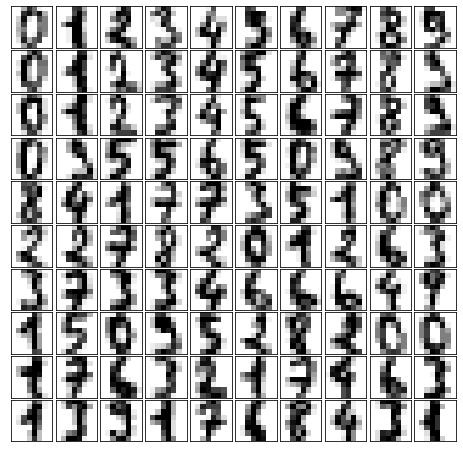

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

## PCA 

To gain intuition on the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [2]:
# Import PCA
from sklearn.decomposition import PCA


## project from 64 to 2 dimensions using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(digits.data)

print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


### Visualize the projected data

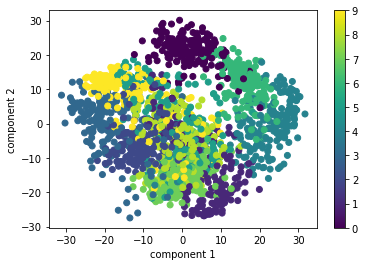

In [3]:
## visualize projected data using scatter plot
plt.scatter(projected[:,0], projected[:,1], c=digits.target)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

**Question:** Based on the scatter plot using first two principal components, can K-means clustering perfectly separate all the classes when only 2 principal components are used? Explain why in 1-2 sentences.

**Answer:** Based on the scatter plot we can see that there are a lot of digits overlapping with other digits. For instance, datapoints representing digit - 9 has a high overlap with datapoints representing digit - 7.  Since k-means clustering assigns each datapoint to any one cluster k-means will not be able to perfectly separate all the classes. In order to minimize the within cluster variance k-means will assign data points to a cluster based on its distance to the cluster center, thus increasing the scope of miscalssification, mainly because of the random initialisation of cluster centers. 

### Choosing the number of components

To decide the number of components to keep, let's look at the cumulative explained variance ratio as a function of the number of components.

0.999999657094298


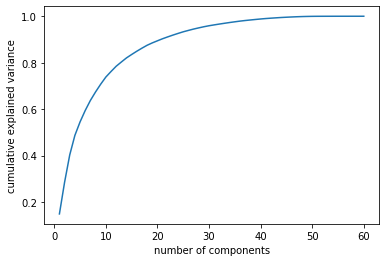

In [4]:
## obtain all the components and plot the cumulatie explained variance with respect to the number of components

explained_variance = []
components = np.arange(1,61,1)
variance=0

for i in components:
    pca = PCA(n_components=i)
    pca.fit(digits.data)
    #print(pca.explained_variance_ratio_)
    explained_variance.append( (pca.explained_variance_ratio_).sum())

print(explained_variance[-1])

#print("90% Variance - 22")
#print("100% Variance - 62")

    
plt.plot(components, explained_variance)

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


**Question:** How many components are needed to contain approximately 90% of the variance? And how many to describe close to 100% of the variance?

**Answer:** Components are needed to contain approximately 90% of the variance: 22

Components are needed to contain approximately 100% of the variance: 62

Use the number of components to keep approximately 90% of the variance to reduce the dimension of the our data.

In [5]:
pca = PCA(n_components=22)
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 22)


## K-means Clustering 

Let's use K-means clustering algorithm to group the data points into 10 different clusters:

In [7]:
from sklearn.cluster import KMeans

## Initiate and fit a K-means model to projected data
kmeans = KMeans(n_clusters=10,random_state=42)
clusters = kmeans.fit_transform(projected)
kmeans.cluster_centers_.shape

(10, 22)

The cluster centers themselves are 10-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. Let's **un-project** these cluster centers back to the original 64 dimensions using inverse_transform of PCA and see what these cluster centers look like:

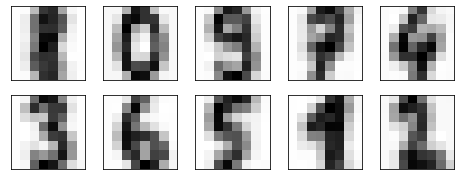

In [8]:
## unproject the cluster centers in reduced dimension back to original dimension. Hint: use inverse_transform in PCA
cluster_centers = kmeans.fit(pca.inverse_transform(projected)).cluster_centers_

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = cluster_centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

**Question:** Can you visually label each of these un-projected cluster centers? If yes, please give a digit label for each of the cluster centers?

**Answer:** Some labels independently are difficult to identify but based on all the labels given we can see the difference.
Label 0: 8

Label 1: 0

Label 2: 9

Label 3: 7

Label 4: 4

Label 5: 3

Label 6: 6

Label 7: 5

Label 8: 1

Label 9: 2

By default, the number of times the K-means algorithm will be run with different centroid **seeds** is 10. The final result will be the best output of n_init consecutive runs in terms of inertia. Let's increase this number to 100 and compare the results.

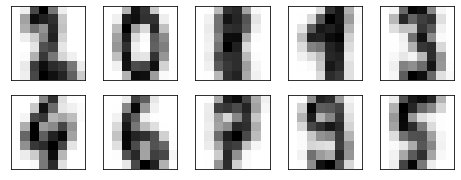

In [9]:
kmeans = KMeans(n_clusters=10, n_init=100,random_state=42)
clusters = kmeans.fit_predict(digits.data)

cluster_centers = kmeans.cluster_centers_

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = cluster_centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

**Question:** Do the cluster centers look similar or different from those returned using only 10 runs?

**Answer:** Since k-mean randomly initialises cluster center it is necessary that the model is run multiple times and we can see that the cluster center look very different from those returned using only 10 runs.

Label 0: 2

Label 1: 0

Label 2: 8

Label 3: 1

Label 4: 3

Label 5: 4

Label 6: 6

Label 7: 7

Label 8: 9

Label 9: 5

### Measure accuracy of K-means clustering

Because K-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them.

In [10]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7924318308291597

## Compare K-means and Gaussian Mixture Models (Expectation Maximization) 

For visualization purposes, let's use first two principal components only in the PCA and compare the results of K-means and GMM.

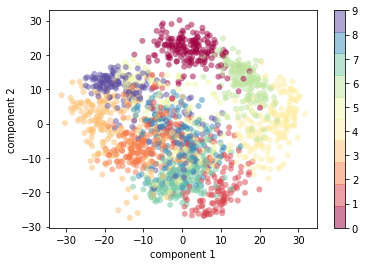

In [18]:
pca = PCA(n_components=2)
projected = pca.fit_transform(digits.data)

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

0.5954368391764051

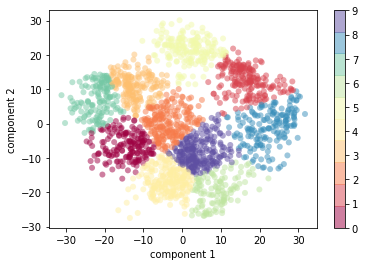

In [21]:
## train a K-means model on projected data, plots the clusters and measure the accuracy

kmeans = KMeans(n_clusters=10,random_state=42)
clusters = kmeans.fit_predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=kmeans.labels_, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

0.6227045075125208

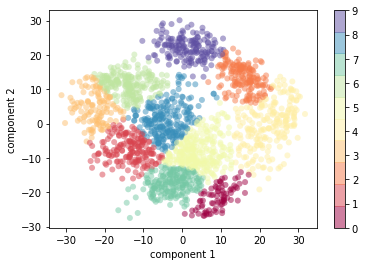

In [22]:
## train and plot GMM

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10,random_state=42)
clusters = gmm.fit_predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=clusters, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

**Question:** Compare the accuracy of K-means and GMM? Can you spot the differences that explain the comparison results in the plots of K-means and GMM clusters?

**Answer:** GMM gives a slightly better accuracy than K-means. This is mainly because GMM allows for overlapping clusters by using soft assignments instead of hard assignments and since GMM is a probalistic clustering model we also see that the clusters formed in GMM are non-spherical making it more efficient. 

## t-SNE for dimensionality reduction 

Let's try t-SNE to reduce the original data dimension to 2 and then use K-means to cluster it.

0.9432387312186978

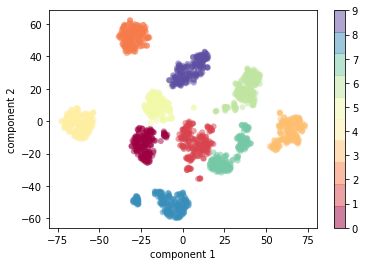

In [23]:
from sklearn.manifold import TSNE

projected = TSNE(n_components=2).fit_transform(digits.data)

kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=kmeans.labels_, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

In [24]:
#PCA with N-components 20
pca = PCA(n_components=20)
projected = pca.fit_transform(digits.data)

In [26]:
## train a K-means model on projected data, plots the clusters and measure the accuracy

kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(projected)

# plt.scatter(projected[:, 0], projected[:, 1],
#             c=kmeans.labels_, edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('Spectral', 10))
# plt.xlabel('component 1')
# plt.ylabel('component 2')
# plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

0.7952142459654981

**Question:** Compare the accuracy resulted from K-means with t-SNE (n_components = 2) with that of K-means with PCA (n_components = 20) and justify your observation (why)?

**Answer:** Accuracy of K-means with t-SNE (n_components = 2) is 94% on the other hand K-means with PCA (n_components = 20) gives an accuracy of 79%. PCA converts n-dimensional data into k-dimensional data and achieves this dimensionality reduction by keeping the top k principal components that maximize the variance in data in lower dimensions. On the other hand, t-SNE is a probabilistic model which finds a lower dimensional embedding of data such that pairwise similarities in the original space are preserved i.e. conditional probability of similar data points will be higher than that of completely different data points. Since we are working with hand written digits, it is important that the original structure of the data is preserved in lower dimensions. Thus we see t-SNE performing better than PCA in this case.